In [1]:
#-------------辅助工具-------------#
import os #文档路径
import numpy as np
import pandas as pd
pd.options.display.max_columns = None  # 显示所有列
pd.set_option('display.float_format', lambda x: '%.4f' % x)  # 取消科学计数法

from time import time #计时
import datetime

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #显示所有输出

import pickle #训练模型的保存与读取
from sklearn.externals import joblib #保存训练模型

#-------------数据可视化工具-------------#
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['Simhei'] # 解决中文乱码问题
plt.rcParams['axes.unicode_minus'] = False # 解决坐标轴刻度负号乱码

#-------------数据预处理工具-------------#
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder #标签编码
from sklearn.preprocessing import OneHotEncoder #独热编码
from sklearn.preprocessing import StandardScaler #标准化

#-------------建模工具-------------#
from sklearn.model_selection import train_test_split  # 划分训练集和测试集
from sklearn.model_selection import cross_val_score #交叉验证
from sklearn.model_selection import GridSearchCV #网格搜索

from sklearn.linear_model import LogisticRegression #逻辑回归
from sklearn.tree import DecisionTreeClassifier #决策树
from sklearn import tree
import graphviz #画决策树
import xgboost #也可作为数据清洗工具，填充缺失值；能接受输入空间存在空值
from sklearn.neural_network import MLPClassifier #多层感知神经网络

from sklearn.pipeline import Pipeline #管道链
from sklearn.pipeline import make_pipeline

#-------------模型评估工具-------------#
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### （一）数据预处理

In [2]:
test_data=pd.read_csv('./df_test.csv')
test_data.columns=['客户ID','产品使用分数','用户地区','性别','年龄','使用累计时间','点数余额','产品服务使用量','是否使用信用卡付月费','是否为活跃用户','估计薪资','购买与否']
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
客户ID          2000 non-null int64
产品使用分数        2000 non-null object
用户地区          2000 non-null object
性别            2000 non-null object
年龄            2000 non-null object
使用累计时间        2000 non-null object
点数余额          2000 non-null object
产品服务使用量       2000 non-null object
是否使用信用卡付月费    2000 non-null object
是否为活跃用户       2000 non-null object
估计薪资          2000 non-null object
购买与否          2000 non-null object
dtypes: int64(1), object(11)
memory usage: 187.6+ KB


In [3]:
for cate in test_data.columns:
    print(cate,'的取值分布：')
    print(test_data[cate].value_counts())
    print('----------------------------------')
# 结论：多个字段有错误值?

客户ID 的取值分布：
6143    1
5466    1
5438    1
7489    1
9467    1
       ..
2728    1
4777    1
683     1
6828    1
6145    1
Name: 客户ID, Length: 2000, dtype: int64
----------------------------------
产品使用分数 的取值分布：
?      541
850     25
678     14
682     12
656     11
      ... 
434      1
844      1
699      1
560      1
493      1
Name: 产品使用分数, Length: 387, dtype: int64
----------------------------------
用户地区 的取值分布：
Taipei      745
?           587
Taichung    344
Tainan      324
Name: 用户地区, dtype: int64
----------------------------------
性别 的取值分布：
Male      732
Female    679
?         589
Name: 性别, dtype: int64
----------------------------------
年龄 的取值分布：
?     564
38     81
33     76
34     73
37     66
     ... 
76      1
79      1
75      1
77      1
88      1
Name: 年龄, Length: 64, dtype: int64
----------------------------------
使用累计时间 的取值分布：
?     569
1     163
2     159
7     159
9     147
5     145
8     144
6     140
3     129
4     120
10     68
0      57
Name: 使用累计时间, dtype: int

In [4]:
# 错误值处理
data_clean_1=test_data.drop(['客户ID'],axis=1)
data_clean_1=data_clean_1.replace('?',np.nan)#填充空值
data_clean_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
产品使用分数        1459 non-null object
用户地区          1413 non-null object
性别            1411 non-null object
年龄            1436 non-null object
使用累计时间        1431 non-null object
点数余额          1409 non-null object
产品服务使用量       1410 non-null object
是否使用信用卡付月费    1372 non-null object
是否为活跃用户       1416 non-null object
估计薪资          1399 non-null object
购买与否          2000 non-null object
dtypes: object(11)
memory usage: 172.0+ KB


In [5]:
# 转化数据类型
data_clean_1['产品使用分数']=data_clean_1['产品使用分数'].astype(dtype='float')
data_clean_1['年龄']=data_clean_1['年龄'].astype(dtype='float')
data_clean_1['点数余额']=data_clean_1['点数余额'].astype(dtype='float')
data_clean_1['估计薪资']=data_clean_1['估计薪资'].astype(dtype='float')
data_clean_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
产品使用分数        1459 non-null float64
用户地区          1413 non-null object
性别            1411 non-null object
年龄            1436 non-null float64
使用累计时间        1431 non-null object
点数余额          1409 non-null float64
产品服务使用量       1410 non-null object
是否使用信用卡付月费    1372 non-null object
是否为活跃用户       1416 non-null object
估计薪资          1399 non-null float64
购买与否          2000 non-null object
dtypes: float64(4), object(7)
memory usage: 172.0+ KB


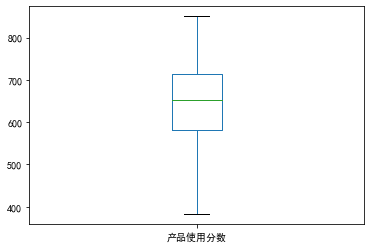

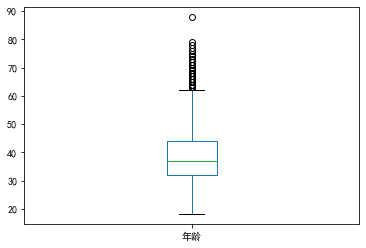

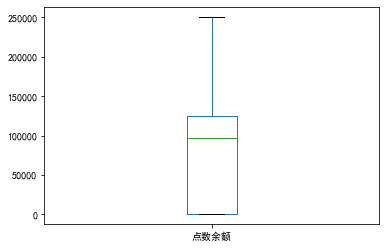

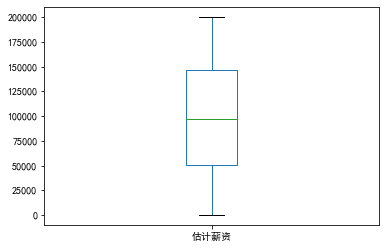

In [6]:
# 箱线图，即四分位法

cates=['产品使用分数', '年龄', '点数余额','估计薪资']
for cate in cates:
    data_clean_1[cate].plot(kind='box')
    plt.show()

(1)类别特征填充

In [7]:
#构造特征空间与标签

fill_data=data_clean_1.copy()

#分类型缺失值填充为99

cates=['用户地区', '性别', '使用累计时间','产品服务使用量', '是否使用信用卡付月费','是否为活跃用户']
fill_data[cates]=fill_data[cates].fillna('99')
fill_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
产品使用分数        1459 non-null float64
用户地区          2000 non-null object
性别            2000 non-null object
年龄            1436 non-null float64
使用累计时间        2000 non-null object
点数余额          1409 non-null float64
产品服务使用量       2000 non-null object
是否使用信用卡付月费    2000 non-null object
是否为活跃用户       2000 non-null object
估计薪资          1399 non-null float64
购买与否          2000 non-null object
dtypes: float64(4), object(7)
memory usage: 172.0+ KB


In [8]:
# 构造算法填充的特征，独热编码，删除cate-99的特征

region_features=pd.get_dummies(fill_data['用户地区'],prefix='用户地区')
region_features=region_features.drop(['用户地区_99'],axis=1)

sex_features=pd.get_dummies(fill_data['性别'],prefix='性别')
sex_features=sex_features.drop(['性别_99'],axis=1)

usetime_features=pd.get_dummies(fill_data['使用累计时间'],prefix='使用累计时间')
usetime_features=usetime_features.drop(['使用累计时间_99'],axis=1)

service_features=pd.get_dummies(fill_data['产品服务使用量'],prefix='产品服务使用量')
service_features=service_features.drop(['产品服务使用量_99'],axis=1)

credict_features=pd.get_dummies(fill_data['是否使用信用卡付月费'],prefix='是否使用信用卡付月费')
credict_features=credict_features.drop(['是否使用信用卡付月费_99'],axis=1)

active_features=pd.get_dummies(fill_data['是否为活跃用户'],prefix='是否为活跃用户')
active_features=active_features.drop(['是否为活跃用户_99'],axis=1)

In [9]:
#构造算法填充的标签，序列编码


cates=['用户地区', '性别', '使用累计时间','产品服务使用量', '是否使用信用卡付月费','是否为活跃用户']

y_data=fill_data[cates]
y_data['用户地区']=y_data['用户地区'].replace('Taipei',0)
y_data['用户地区']=y_data['用户地区'].replace('Taichung',1)
y_data['用户地区']=y_data['用户地区'].replace('Tainan',2)

y_data['性别']=y_data['性别'].replace('Male',0)
y_data['性别']=y_data['性别'].replace('Female',1)

y_data.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

,用户地区,性别,使用累计时间,产品服务使用量,是否使用信用卡付月费,是否为活跃用户
0,1,1,4,99,1,0
1,1,99,9,1,99,1
2,0,99,1,2,1,1
3,2,0,99,2,0,0
4,99,1,10,99,1,99


In [10]:
# 填充，此处填充，直接用训练集训练的模型

model_load_file = open(r'xgb_fill_0.model', 'rb')
xgb_fill_0_r = pickle.load(model_load_file)
model_load_file.close()

model_load_file = open(r'xgb_fill_1.model', 'rb')
xgb_fill_1_r = pickle.load(model_load_file)
model_load_file.close()

model_load_file = open(r'xgb_fill_2.model', 'rb')
xgb_fill_2_r = pickle.load(model_load_file)
model_load_file.close()

model_load_file = open(r'xgb_fill_3.model', 'rb')
xgb_fill_3_r = pickle.load(model_load_file)
model_load_file.close()

model_load_file = open(r'xgb_fill_4.model', 'rb')
xgb_fill_4_r = pickle.load(model_load_file)
model_load_file.close()

model_load_file = open(r'xgb_fill_5.model', 'rb')
xgb_fill_5_r = pickle.load(model_load_file)
model_load_file.close()

model_load_file = open(r'ohe_fill.model', 'rb')
ohe_fill_r = pickle.load(model_load_file)
model_load_file.close()

In [11]:
cates=['用户地区', '性别', '使用累计时间','产品服务使用量', '是否使用信用卡付月费','是否为活跃用户']

x_cates=['产品使用分数', '年龄', '点数余额','估计薪资']

dummies_f7=[ region_features,sex_features,usetime_features,service_features,credict_features,active_features,fill_data[x_cates] ]

for i in range(6):

    print('填充有缺失值的特征：',cates[i])
    print('第一步：构造特征与标签--------------------')

    Y=y_data[cates[i]]  #Serise
    #Y_train=Y[Y!='99'] #没有缺失值
    Y_test=Y[Y=='99']  #缺失值，待预测   
    
    objs=[ region_features,sex_features,usetime_features,service_features,credict_features,active_features,fill_data[x_cates] ]
    df=pd.concat(objs,axis=1)    
    ob=list(dummies_f7[i].columns)
    X=df.drop(labels=ob,axis=1)
    #X_train=X[Y!='99']
    X_test=X[Y=='99']

    print('第二步：预测填充------------------------')
    if i==0:
        Y_predict=xgb_fill_0_r.predict(X_test)
    elif i==1:
        Y_predict=xgb_fill_1_r.predict(X_test)
    elif i==2:
        Y_predict=xgb_fill_2_r.predict(X_test)
    elif i==3:
        Y_predict=xgb_fill_3_r.predict(X_test)
    elif i==4:
        Y_predict=xgb_fill_4_r.predict(X_test)
    else:
        Y_predict=xgb_fill_5_r.predict(X_test)        
        
    #预测结果赋值到缺失值地方
    y_data[ cates[i] ][ y_data[ cates[i] ]=='99' ]=Y_predict

填充有缺失值的特征： 用户地区
第一步：构造特征与标签--------------------
第二步：预测填充------------------------
填充有缺失值的特征： 性别
第一步：构造特征与标签--------------------
第二步：预测填充------------------------
填充有缺失值的特征： 使用累计时间
第一步：构造特征与标签--------------------
第二步：预测填充------------------------
填充有缺失值的特征： 产品服务使用量
第一步：构造特征与标签--------------------
第二步：预测填充------------------------
填充有缺失值的特征： 是否使用信用卡付月费
第一步：构造特征与标签--------------------
第二步：预测填充------------------------
填充有缺失值的特征： 是否为活跃用户
第一步：构造特征与标签--------------------
第二步：预测填充------------------------


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
data_clean_2=data_clean_1.copy()
data_clean_2.info()
cates=['用户地区', '性别', '使用累计时间','产品服务使用量', '是否使用信用卡付月费','是否为活跃用户']
print('--------------------')
data_clean_2[cates]=y_data  #将分类型特征填充结果赋值给data_clean_2
data_clean_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
产品使用分数        1459 non-null float64
用户地区          1413 non-null object
性别            1411 non-null object
年龄            1436 non-null float64
使用累计时间        1431 non-null object
点数余额          1409 non-null float64
产品服务使用量       1410 non-null object
是否使用信用卡付月费    1372 non-null object
是否为活跃用户       1416 non-null object
估计薪资          1399 non-null float64
购买与否          2000 non-null object
dtypes: float64(4), object(7)
memory usage: 172.0+ KB
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
产品使用分数        1459 non-null float64
用户地区          2000 non-null object
性别            2000 non-null object
年龄            1436 non-null float64
使用累计时间        2000 non-null object
点数余额          1409 non-null float64
产品服务使用量       2000 non-null object
是否使用信用卡付月费    2000 non-null object
是否为活跃用户       2000 non-null object
估计薪资

(2)数值型特征填充

In [15]:
#构造特征空间与标签

cates=['产品使用分数', '年龄', '点数余额','估计薪资']
y4_data=data_clean_2[cates]

cates=['用户地区', '性别', '使用累计时间','产品服务使用量', '是否使用信用卡付月费','是否为活跃用户']
result=ohe_fill_r.transform( data_clean_2[cates] )
df_catefeature=pd.DataFrame(result.toarray(),columns=ohe_fill_r.get_feature_names())

In [16]:
df_catefeature.shape
df_catefeature.head()

(2000, 24)

,x0_0.0,x0_1.0,x0_2.0,x1_0.0,x1_1.0,x2_0.0,x2_1.0,x2_2.0,x2_3.0,x2_4.0,x2_5.0,x2_6.0,x2_7.0,x2_8.0,x2_9.0,x2_10.0,x3_1.0,x3_2.0,x3_3.0,x3_4.0,x4_0.0,x4_1.0,x5_0.0,x5_1.0
0,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000
1,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000
2,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000
3,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000
4,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000


In [17]:
# 填充，此处填充，直接用训练集训练的模型

model_load_file = open(r'xgbr_fill_0.model', 'rb')
xgbr_fill_0_r = pickle.load(model_load_file)
model_load_file.close()

model_load_file = open(r'xgbr_fill_1.model', 'rb')
xgbr_fill_1_r = pickle.load(model_load_file)
model_load_file.close()

model_load_file = open(r'xgbr_fill_2.model', 'rb')
xgbr_fill_2_r = pickle.load(model_load_file)
model_load_file.close()

model_load_file = open(r'xgbr_fill_3.model', 'rb')
xgbr_fill_3_r = pickle.load(model_load_file)
model_load_file.close()

In [18]:
# 填充

cates=['产品使用分数', '年龄', '点数余额','估计薪资']
dummies_f7=[ data_clean_2[cates] ,df_catefeature ]

for i in range(4):
    
    print('填充有缺失值的特征：',cates[i])
    print('第一步：构造特征与标签--------------------')

    Y=y4_data[cates[i]]  #Serise
    Y_train=Y[Y.notnull()] #没有缺失值，用于建模
    Y_test=Y[Y.isnull()]  #缺失值，待预测
    
    
    objs=[ data_clean_2[cates] ,df_catefeature ]
    df=pd.concat(objs,axis=1)    
    ob=cates[i]
    X=df.drop(labels=ob,axis=1)
    X_train=X[Y.notnull()]
    X_test=X[Y.isnull()]

    print('第二步：预测填充------------------------')
    if i==0:
        Y_predict=xgbr_fill_0_r.predict(X_test)
    elif i==1:
        Y_predict=xgbr_fill_1_r.predict(X_test)
    elif i==2:
        Y_predict=xgbr_fill_2_r.predict(X_test)
    else:
        Y_predict=xgbr_fill_3_r.predict(X_test)
        
    #预测结果赋值到缺失值地方
    y4_data[ cates[i] ][ y4_data[ cates[i] ].isnull() ]=Y_predict

填充有缺失值的特征： 产品使用分数
第一步：构造特征与标签--------------------
第二步：预测填充------------------------
填充有缺失值的特征： 年龄
第一步：构造特征与标签--------------------
第二步：预测填充------------------------
填充有缺失值的特征： 点数余额
第一步：构造特征与标签--------------------
第二步：预测填充------------------------
填充有缺失值的特征： 估计薪资
第一步：构造特征与标签--------------------
第二步：预测填充------------------------


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
data_clean_3=data_clean_2.copy()
data_clean_3.info()
cates=['产品使用分数', '年龄', '点数余额','估计薪资']
print('--------------------')
data_clean_3[cates]=y4_data  #将数值型特征填充结果赋值给data_clean_3
data_clean_3.info()

data_clean_4=data_clean_3.copy()
data_clean_4['客户ID']=test_data['客户ID']
data_clean_4.to_csv('./clean_df_test.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
产品使用分数        1459 non-null float64
用户地区          2000 non-null object
性别            2000 non-null object
年龄            1436 non-null float64
使用累计时间        2000 non-null object
点数余额          1409 non-null float64
产品服务使用量       2000 non-null object
是否使用信用卡付月费    2000 non-null object
是否为活跃用户       2000 non-null object
估计薪资          1399 non-null float64
购买与否          2000 non-null object
dtypes: float64(4), object(7)
memory usage: 172.0+ KB
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
产品使用分数        2000 non-null float64
用户地区          2000 non-null object
性别            2000 non-null object
年龄            2000 non-null float64
使用累计时间        2000 non-null object
点数余额          2000 non-null float64
产品服务使用量       2000 non-null object
是否使用信用卡付月费    2000 non-null object
是否为活跃用户       2000 non-null object
估计薪资

### （二）预测

#### （1）关键特征,XGBoost

In [2]:
#构造特征空间

data=pd.read_csv('./clean_df_test.csv',index_col='Unnamed: 0')

model_load_file = open(r'ohe_keyf.model', 'rb')
ohe_keyf_r = pickle.load(model_load_file)
model_load_file.close()

cates=['用户地区', '性别','产品服务使用量', '是否为活跃用户']
result=ohe_keyf_r.transform( data[cates] )
df_catefeature=pd.DataFrame(result.toarray(),columns=ohe_keyf_r.get_feature_names())

cates=['产品使用分数', '年龄', '点数余额']
objs=[df_catefeature,data[cates]]
X=pd.concat(objs,axis=1)

#导入预测模型
model_load_file = open(r'best_2_XGBClassifier.model', 'rb')
xgb_2_r = pickle.load(model_load_file)
model_load_file.close()

#预测并保存

Y_pre=xgb_2_r.predict(X)

data['Predicted_Results']=Y_pre
results=data[['客户ID','Predicted_Results']]
results.to_csv('./results_xgb_2.csv',index=False)

results.Predicted_Results.value_counts()

0    1810
1     190
Name: Predicted_Results, dtype: int64

#### （2）关键特征,MLP神经网络

In [3]:
#构造特征空间

data=pd.read_csv('./clean_df_test.csv',index_col='Unnamed: 0')

model_load_file = open(r'ohe_keyf.model', 'rb')
ohe_keyf_r = pickle.load(model_load_file)
model_load_file.close()

cates=['用户地区', '性别','产品服务使用量', '是否为活跃用户']
result=ohe_keyf_r.transform( data[cates] )
df_catefeature=pd.DataFrame(result.toarray(),columns=ohe_keyf_r.get_feature_names())

cates=['产品使用分数', '年龄', '点数余额']
objs=[df_catefeature,data[cates]]
X=pd.concat(objs,axis=1)

model_load_file = open(r'ss.model', 'rb')
ss_r = pickle.load(model_load_file)
model_load_file.close()

X_mm=ss_r.transform(X)

#导入预测模型
model_load_file = open(r'best_1_MLPClassifier.model', 'rb')
mlpc_1_r = pickle.load(model_load_file)
model_load_file.close()

#预测并保存

Y_pre=mlpc_1_r.predict(X_mm)

data['Predicted_Results']=Y_pre
results=data[['客户ID','Predicted_Results']]
results.to_csv('./results_mlpc.csv',index=False)

results.Predicted_Results.value_counts()

0    1778
1     222
Name: Predicted_Results, dtype: int64

#### （3）关键特征,随机森林

In [4]:
#构造特征空间

data=pd.read_csv('./clean_df_test.csv',index_col='Unnamed: 0')

model_load_file = open(r'ohe_keyf.model', 'rb')
ohe_keyf_r = pickle.load(model_load_file)
model_load_file.close()

cates=['用户地区', '性别','产品服务使用量', '是否为活跃用户']
result=ohe_keyf_r.transform( data[cates] )
df_catefeature=pd.DataFrame(result.toarray(),columns=ohe_keyf_r.get_feature_names())

cates=['产品使用分数', '年龄', '点数余额']
objs=[df_catefeature,data[cates]]
X=pd.concat(objs,axis=1)

#导入预测模型
model_load_file = open(r'best_1_RandomForestClassifier.model', 'rb')
rfc_1_r = pickle.load(model_load_file)
model_load_file.close()

#预测并保存

Y_pre=rfc_1_r.predict(X)

data['Predicted_Results']=Y_pre
results=data[['客户ID','Predicted_Results']]
results.to_csv('./results_rfc.csv',index=False)

results.Predicted_Results.value_counts()

0    1845
1     155
Name: Predicted_Results, dtype: int64

### （三）比较不同模型的预测结果

In [5]:
results_xgb_2=pd.read_csv('./results_xgb_2.csv',index_col='客户ID')
results_xgb_2.columns=['xgb_2_pre']

results_mlpc=pd.read_csv('./results_mlpc.csv',index_col='客户ID')
results_mlpc.columns=['mlpc_pre']

results_rfc=pd.read_csv('./results_rfc.csv',index_col='客户ID')
results_rfc.columns=['rfc_pre']

pre_all=pd.concat([results_xgb_2,results_mlpc,results_rfc],axis=1)
pre_all.head(20)

,xgb_2_pre,mlpc_pre,rfc_pre
客户ID,,,
9222,0,0,0
3931,1,1,0
1242,0,0,0
3639,0,0,0
7951,0,0,0
1803,0,0,0
1459,0,0,0
3538,0,0,0
8924,1,1,1


In [6]:
df=['xgb_2_pre','mlpc_pre','rfc_pre']
for x in range(3):
    for y in range(x+1,3):
        pd.crosstab(index=pre_all[df[x]],columns=pre_all[df[y]])

mlpc_pre,0,1
xgb_2_pre,,
0,1753,57
1,25,165


rfc_pre,0,1
xgb_2_pre,,
0,1807,3
1,38,152


rfc_pre,0,1
mlpc_pre,,
0,1763,15
1,82,140


### （四）模型融合

In [8]:
def voting3(x):
    if x>1:
        return 1
    else:
        return 0

pre_all['voting3_pre']=pre_all['xgb_2_pre']+pre_all['mlpc_pre']+pre_all['rfc_pre']
pre_all['voting3_pre']=pre_all['voting3_pre'].map(voting3)
pre_all['voting3_pre'].to_csv('./voting3_pre.csv')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  if __name__ == '__main__':


In [9]:
def voting2(x):
    if x>0:
        return 1
    else:
        return 0

pre_all['voting2_pre']=pre_all['mlpc_pre']+pre_all['rfc_pre']
pre_all['voting2_pre']=pre_all['voting2_pre'].map(voting3)
pre_all['voting2_pre'].to_csv('./voting2_pre.csv')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  if __name__ == '__main__':


In [10]:
def voting22(x):
    if x>0:
        return 1
    else:
        return 0

pre_all['voting22_pre']=pre_all['mlpc_pre']+pre_all['xgb_2_pre']
pre_all['voting22_pre']=pre_all['voting22_pre'].map(voting3)
pre_all['voting22_pre'].to_csv('./voting22_pre.csv')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  if __name__ == '__main__':


## 附探索

In [24]:
#构造特征空间

data=pd.read_csv('./clean_df_test.csv',index_col='Unnamed: 0')

model_load_file = open(r'ohe_keyf.model', 'rb')
ohe_keyf_r = pickle.load(model_load_file)
model_load_file.close()

cates=['用户地区', '性别','产品服务使用量', '是否为活跃用户']
result=ohe_keyf_r.transform( data[cates] )
df_catefeature=pd.DataFrame(result.toarray(),columns=ohe_keyf_r.get_feature_names())

cates=['产品使用分数', '年龄', '点数余额']
objs=[df_catefeature,data[cates]]
X=pd.concat(objs,axis=1)

#导入预测模型
model_load_file = open(r'best_b_XGBClassifier.model', 'rb')
xgb_b_r = pickle.load(model_load_file)
model_load_file.close()

#预测并保存

Y_pre=xgb_b_r.predict(X)

data['Predicted_Results']=Y_pre
results=data[['客户ID','Predicted_Results']]
results.to_csv('./results_xgb_b.csv',index=False)

results.Predicted_Results.value_counts()

0    1560
1     440
Name: Predicted_Results, dtype: int64